In [127]:
import pyqg
import pyqg_generative.tools.operators as op
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pyqg_parameterization_benchmarks.coarsening_ops as ppb
from pyqg_generative.tools.spectral_tools import *
%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [128]:
def error(x,y):
    return float(np.mean(np.abs(x-y)))

In [129]:
X = np.random.randn(64,64)
Y = np.ones((64,64))
q = xr.open_dataset('/scratch/pp2681/pyqg_generative/highres/online_eddy.nc').isel(run=0,time=-1,lev=0).q.values.astype('float64')

nc=32, error=0.12298056530712356
nc=16, error=0.03498174124288905
nc=8, error=0.003322149725908563
nc=4, error=0.0010338423428684009


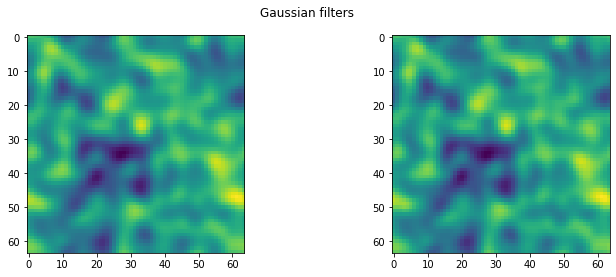

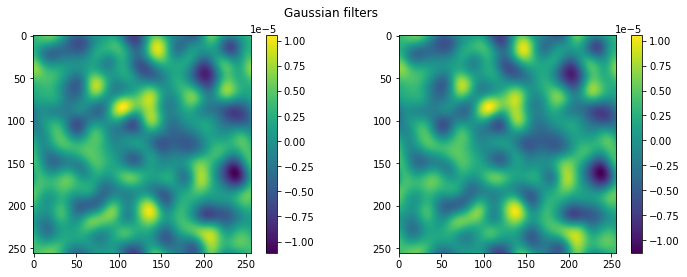

In [138]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.imshow(op.gauss_filter(X, 8))
plt.subplot(1,2,2); plt.imshow(op.gcm_filter(X, 8))
plt.suptitle('Gaussian filters')
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.imshow(op.gauss_filter(q, 8)); plt.colorbar()
plt.subplot(1,2,2); plt.imshow(op.gcm_filter(q, 8)); plt.colorbar()
plt.suptitle('Gaussian filters')

for nc in [32, 16, 8, 4]:
    print(f'nc={nc}, error={error(op.gauss_filter(X, nc), op.gcm_filter(X, nc))}')

Text(0.5, 0.98, 'Model filter')

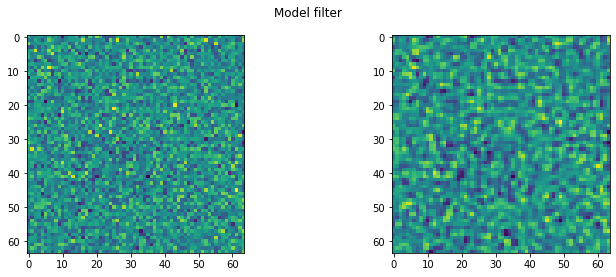

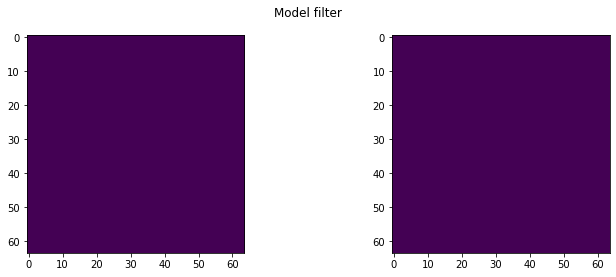

In [139]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.imshow(X)
plt.subplot(1,2,2); plt.imshow(op.model_filter(X))
plt.suptitle('Model filter')
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.imshow(Y)
plt.subplot(1,2,2); plt.imshow(op.model_filter(Y))
plt.suptitle('Model filter')

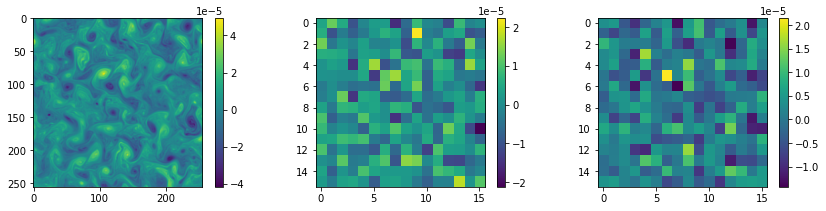

In [146]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.imshow(q); plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(op.cut_off(q,16)); plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(op.coarsegrain(q,16)); plt.colorbar()
plt.tight_layout()

# Commutation errors

In [149]:
error(op.gauss_filter(op.cut_off(X, 16), 8), op.cut_off(op.gauss_filter(X, 8), 16)) / np.mean(np.abs(X))

3.860157180944893e-17

In [150]:
error(op.gcm_filter(op.coarsegrain(X, 16), 8), op.coarsegrain(op.gcm_filter(X, 8), 16)) / np.mean(np.abs(X))

0.07407299705179861

In [151]:
error(op.gcm_filter(op.gauss_filter(X, 16), 8), op.gauss_filter(op.gcm_filter(X, 8), 16)) / np.mean(np.abs(X))

4.112155445159251e-17

/state/partition1/job-22516643/ipykernel_4149323/1260507905.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(np.fft.rfftn(op.clean_2h(X)-X))))


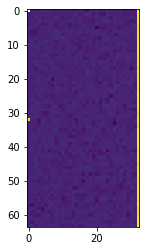

In [157]:
plt.imshow(np.log(np.abs(np.fft.rfftn(op.clean_2h(X)-X))))

# Try different formats

In [158]:
ds = xr.open_dataset('/scratch/pp2681/pyqg_generative/highres/online_eddy.nc')

In [159]:
op1 = op.gauss_filter

In [161]:
op1(np.stack((X,X)), nc=32)[0]

array([[ 0.37029193, -0.18597402, -0.14299566, ..., -0.71332653,
        -0.58317242,  0.9171206 ],
       [ 0.38903339, -0.22059381,  0.21385107, ..., -0.83876548,
        -0.49021739,  1.02607275],
       [ 0.51272305, -0.20549735, -0.06417901, ..., -0.21429591,
        -0.04477081,  0.39956505],
       ...,
       [ 0.20283554,  0.04576424,  0.80778057, ...,  0.28687134,
         0.37623681,  0.61023335],
       [ 0.30373948,  0.80231667,  0.68231102, ...,  0.17260362,
        -0.18804534,  0.5444011 ],
       [-0.08624721,  0.26735309, -0.01200129, ..., -0.27359181,
        -0.45318412,  0.66954238]])

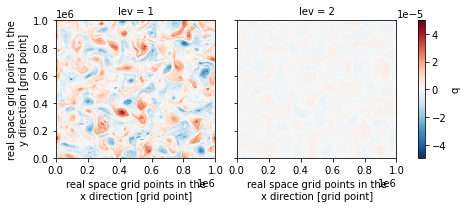

In [162]:
op.model_filter(ds.q.isel(run=0,time=-1), nc=32).plot(col='lev')


# Operators

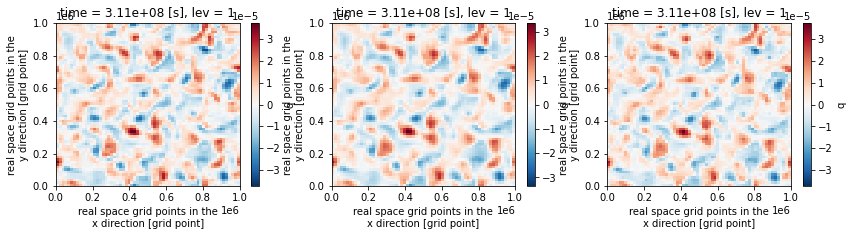

In [165]:
q = ds.q.isel(run=0, time=-1,lev=0)
plt.figure(figsize=(14,3))
plt.subplot(1,3,1)
op.Operator1(q, nc=64).plot()
plt.subplot(1,3,2)
op.Operator2(q, nc=64).plot()
plt.subplot(1,3,3)
op.Operator3(q, nc=64).plot()

# Comparison of operators to Andrew ones. Note the error only due to removing 2h harmonics!

In [166]:
m = pyqg.QGModel(nx=256, log_level=0)
q = ds.q.isel(run=0, time=-1).astype('float64')
q = q - q.mean(('x','y'))
m.q = q.values

In [168]:
def plot_error(Andrew, Me, qf, labels=('Andrew', 'Me')):
    print(f'mean Andrew = {float(Andrew.mean())}, mean Me = {float(Me.mean())}')
    try:
        print(f'Relative error = {float(((Andrew-Me)**2).mean() / (Andrew**2).mean())}')
    except:
        pass
    plt.figure(figsize=(16,3))
    plt.subplot(1,5,1)
    plt.imshow(Andrew); plt.colorbar(); plt.title(labels[0])
    plt.subplot(1,5,2)
    plt.imshow(Me); plt.colorbar(); plt.title(labels[1])
    try:
        err = Andrew-Me
        plt.subplot(1,5,3)
        plt.imshow(err); plt.colorbar(); plt.title('Difference')
        plt.subplot(1,5,4)
        plt.imshow(np.abs(np.fft.rfftn(err)))
        plt.title('Spectrum of error')
    except:
        pass
    plt.subplot(1,5,5)
    _m = pyqg.QGModel(nx=Andrew.shape[0])
    try:
        error_spec = calc_ispec(_m,np.real(np.fft.rfftn(qf) * np.conj(np.fft.rfftn(err))), averaging=False, truncate=False)
        plt.semilogx(error_spec[0], np.abs(error_spec[1]), label='Error')
    except:
        pass
    try:
        Andrew_spec = calc_ispec(_m,np.real(np.fft.rfftn(qf) * np.conj(np.fft.rfftn(Andrew))), averaging=False, truncate=False)
        Me_spec = calc_ispec(_m,np.real(np.fft.rfftn(qf) * np.conj(np.fft.rfftn(Me))), averaging=False, truncate=False)
        plt.semilogx(Andrew_spec[0], np.abs(Andrew_spec[1]), label=labels[0], color='y')
        plt.semilogx(Me_spec[0], np.abs(Me_spec[1]), label=labels[1], ls='--', color='k')
    except:
        pass
    plt.legend()
    plt.title('Cospectrum of error')
    return err

def plot_operators(opAndrew, opMe):
    Andrew = opAndrew(m, 64).m2.q[1]
    Me = opMe(q, 64)[1]
    qf = op.Operator3(q, 64)[1]
    return plot_error(Andrew, Me, qf)

INFO:  Logger initialized


mean Andrew = 3.3087224502121107e-23, mean Me = 2.6469779601696886e-23
Relative error = 1.5206460403894009e-31


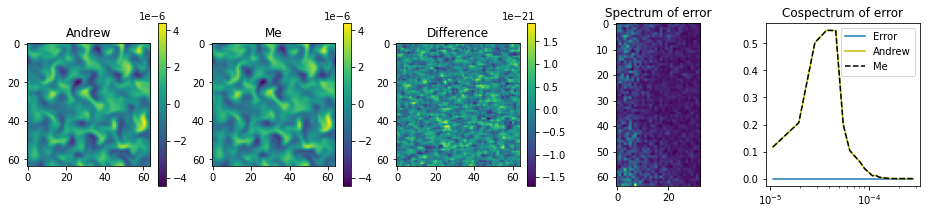

In [169]:
err1 = plot_operators(ppb.Operator1, op.Operator1);

INFO:  Logger initialized


mean Andrew = 2.6469779601696886e-23, mean Me = 1.9852334701272664e-23
Relative error = 1.4021061218961085e-31


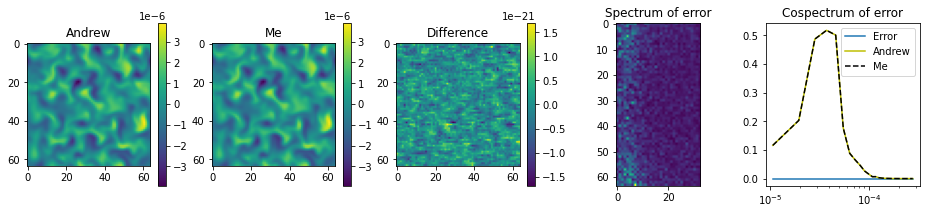

In [170]:
err2 = plot_operators(ppb.Operator2, op.Operator2);

INFO:  Logger initialized


mean Andrew = 3.3087224502121107e-23, mean Me = 3.3087224502121107e-23
Relative error = 0.0


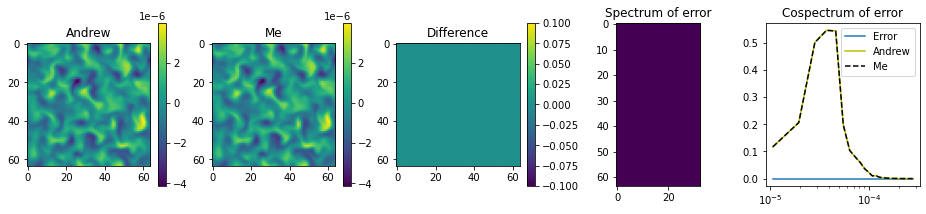

In [171]:
err3 = plot_operators(ppb.Operator3, op.Operator3)

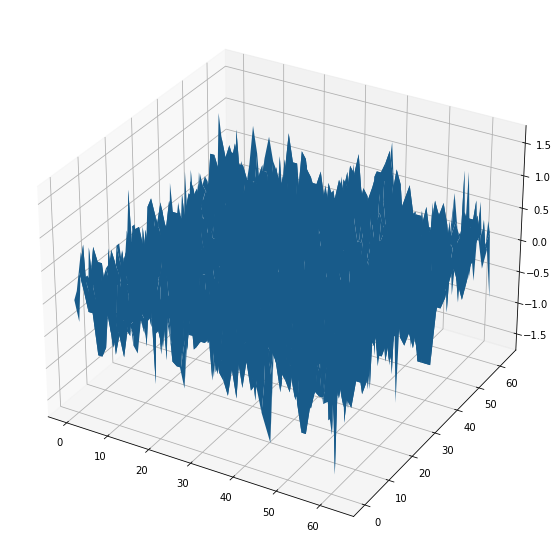

In [172]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(*np.meshgrid(range(64),range(64)), err2)

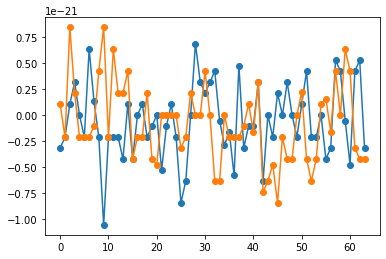

In [173]:
plt.plot(err2[:,1], marker='o')
plt.plot(err2[1,:], marker='o')

# Computation of subgrid flux

In [176]:
def plot_fluxes(opAndrew, opMe):
    Andrew = -opAndrew(m, 64).subgrid_fluxes('q')[0][0]
    Me = op.PV_subgrid_flux(q.values, 64, opMe, {})[0][0]
    qf = op.Operator1(q, 64)[0]
    return plot_error(Andrew, Me, qf)

mean Andrew = -2.759081152049734e-14, mean Me = -2.7590811523806063e-14
Relative error = 8.992763319204762e-30


INFO:  Logger initialized


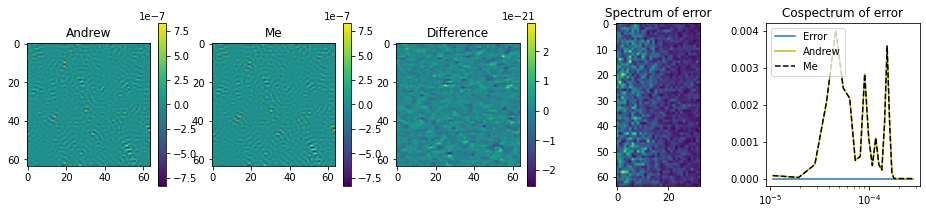

In [177]:
err1 = plot_fluxes(ppb.Operator1, op.Operator1)

INFO:  Logger initialized


mean Andrew = 4.030353370523876e-10, mean Me = 4.030353370523688e-10
Relative error = 2.629279619597664e-29


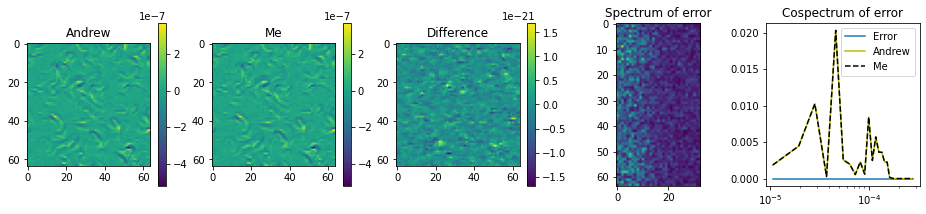

In [178]:
err2 = plot_fluxes(ppb.Operator2, op.Operator2)

INFO:  Logger initialized


mean Andrew = 2.062693068280203e-10, mean Me = 2.0626930682801493e-10
Relative error = 2.4289716285433156e-30


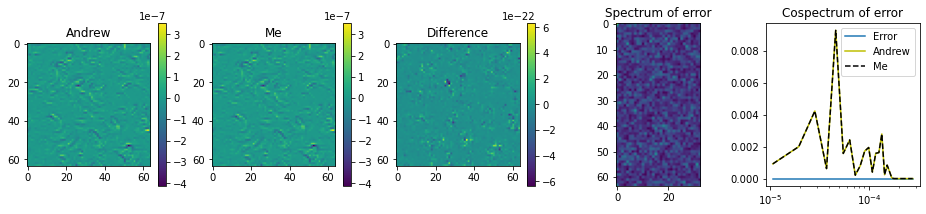

In [179]:
err3 = plot_fluxes(ppb.Operator3, op.Operator3)

# Computation of subgrid forcing

In [182]:
def plot_forces(opAndrew, opMe):
    Andrew = -opAndrew(m, 64).subgrid_forcing('q')[1]
    Me = op.PV_subgrid_forcing(q.values, 64, opMe, {})[1]
    qf = op.Operator3(q, 64)[1]
    return plot_error(Andrew, Me, qf)

INFO:  Logger initialized


mean Andrew = -2.662405555120915e-30, mean Me = -4.7578173346142275e-30
Relative error = 9.683933482991983e-29


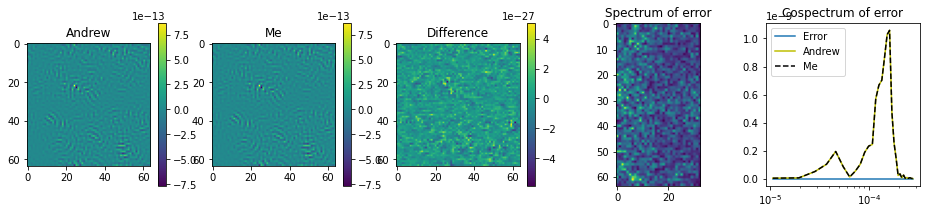

In [183]:
err1 = plot_forces(ppb.Operator1, op.Operator1)

INFO:  Logger initialized


mean Andrew = -1.7749370367472766e-30, mean Me = -2.908924588002481e-30
Relative error = 1.447474834633293e-28


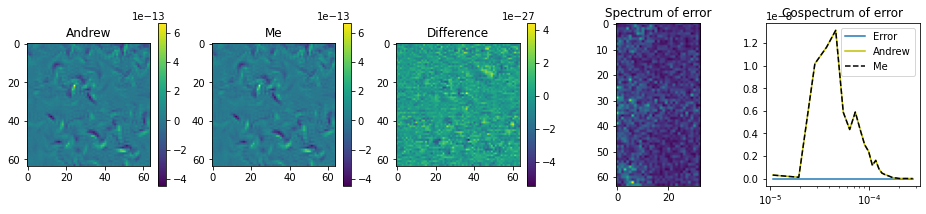

In [184]:
err2 = plot_forces(ppb.Operator2, op.Operator2)

mean Andrew = 1.9721522630525295e-31, mean Me = -2.711709361697228e-31
Relative error = 5.705730724889218e-30


INFO:  Logger initialized


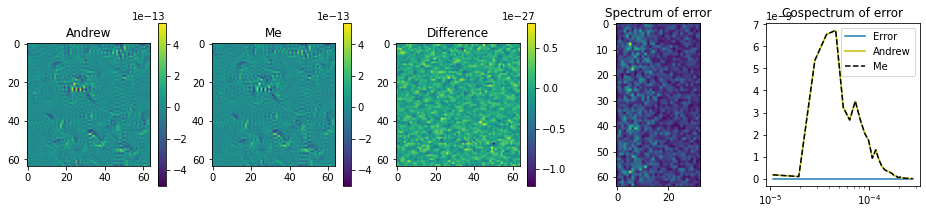

In [185]:
err3 = plot_forces(ppb.Operator3, op.Operator3)

# Commutation errors between subgrid and subfilter fluxes

In [186]:
def plot_commutation(opAndrew, opMe):
    qf = op.Operator3(q, 64)[0]
    
    forcing = -opAndrew(m, 64).subgrid_forcing('q')[0]
    flux = - op.divergence(*opAndrew(m, 64).subgrid_fluxes('q'))[0]
    plot_error(forcing, flux, qf, labels=('forcing', 'flux'))
    plt.suptitle('Andrew code', y=1.05)
    
    forcing = op.PV_subgrid_forcing(q.values, 64, opMe, {})[0]
    flux = op.divergence(*op.PV_subgrid_flux(q.values, 64, opMe, {}))[0]
    plot_error(forcing, flux, qf, labels=('forcing', 'flux'))
    plt.suptitle('My code', y=1.05)
    
    Andrew = - op.divergence(*opAndrew(m, 64).subgrid_fluxes('q'))[0]
    Me = op.divergence(*op.PV_subgrid_flux(q.values, 64, opMe, {}))[0]
    plot_error(Andrew, Me, qf)
    plt.suptitle('Andrew code cs mine', y=1.05)

INFO:  Logger initialized


mean Andrew = 1.8932661725304283e-29, mean Me = -2.2876966251409342e-29
Relative error = 8.784658742041497e-30


INFO:  Logger initialized


mean Andrew = -1.9484864358958992e-28, mean Me = -1.0255191767873153e-29
Relative error = 1.0270101249041803e-29
mean Andrew = -2.2876966251409342e-29, mean Me = -1.0255191767873153e-29
Relative error = 2.3380731446222186e-29


INFO:  Logger initialized


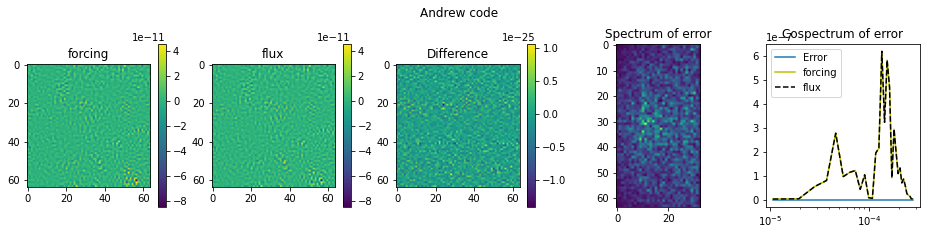

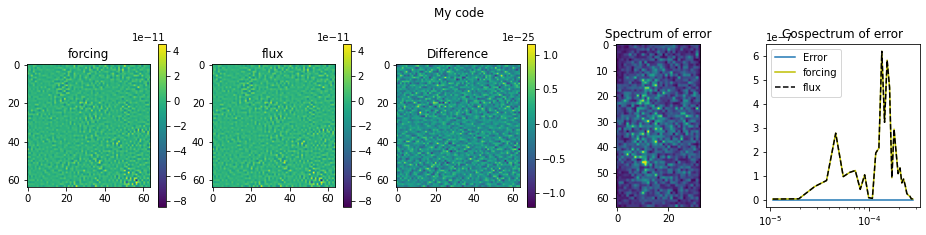

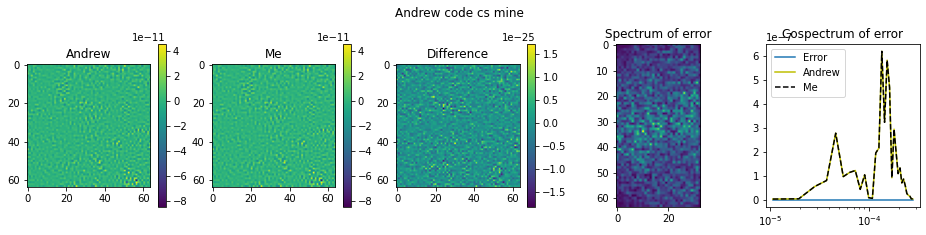

In [187]:
plot_commutation(ppb.Operator1, op.Operator1)

INFO:  Logger initialized


mean Andrew = 2.3665827156630354e-29, mean Me = -3.1554436208840472e-30
Relative error = 0.0030188171994093276


INFO:  Logger initialized


mean Andrew = -3.155443620884047e-29, mean Me = 6.310887241768095e-30
Relative error = 0.0030188171994093302
mean Andrew = -3.1554436208840472e-30, mean Me = 6.310887241768095e-30
Relative error = 5.208973764207534e-29


INFO:  Logger initialized


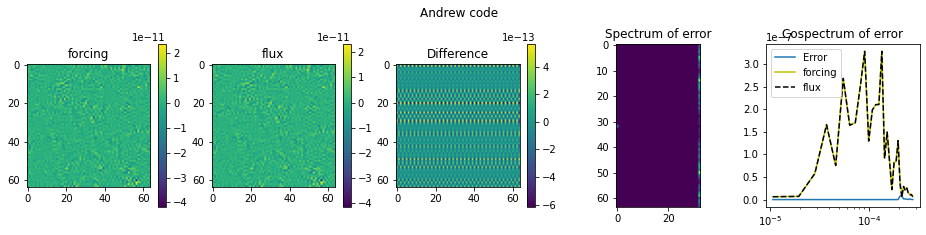

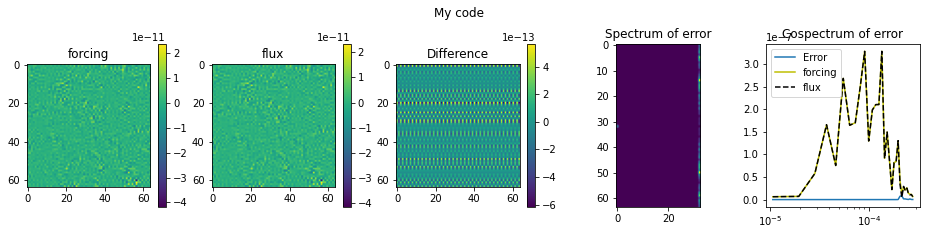

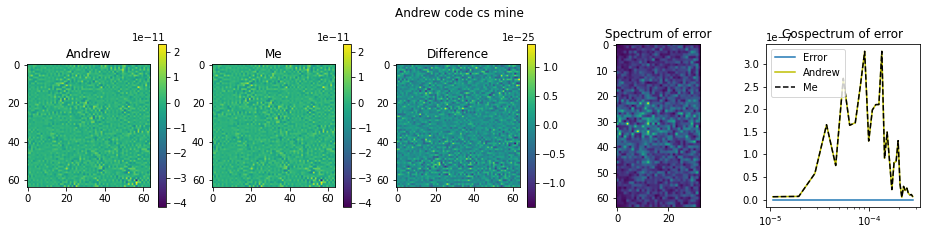

In [188]:
plot_commutation(ppb.Operator2, op.Operator2)

INFO:  Logger initialized


mean Andrew = -4.9698237028923744e-29, mean Me = -1.4199496293978212e-29
Relative error = 0.6068221394889677


INFO:  Logger initialized


mean Andrew = -6.03478592494074e-29, mean Me = -2.4454688061851366e-29
Relative error = 0.6068221394889677


INFO:  Logger initialized


mean Andrew = -1.4199496293978212e-29, mean Me = -2.4454688061851366e-29
Relative error = 3.59070457695007e-30


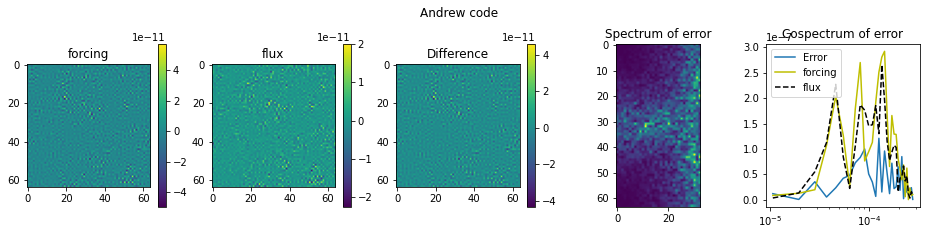

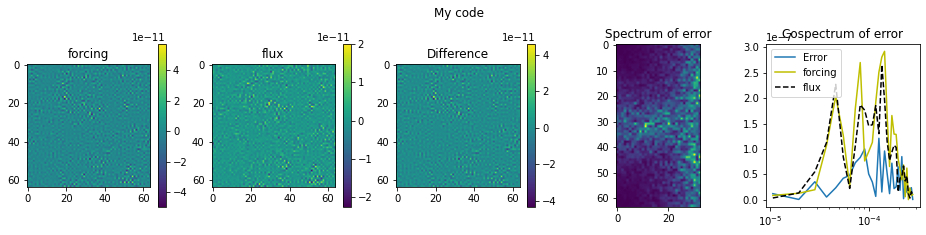

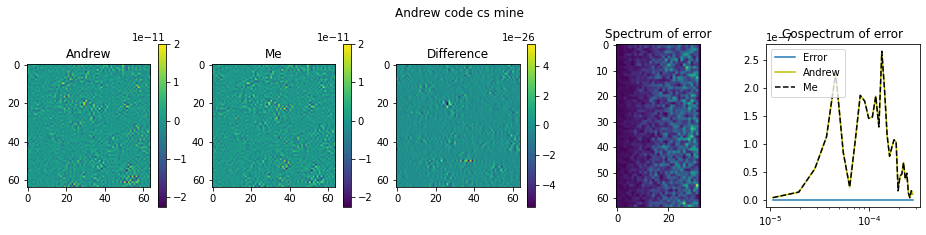

In [189]:
plot_commutation(ppb.Operator3, op.Operator3)

# Is there difference between total forcing and advection forcing?

In [195]:
def plot_advection_total(opAndrew, opMe):
    qf = op.Operator3(q, 64)[0]
    
    advection = -opAndrew(m, 64).subgrid_forcing('q')[0]
    total = opAndrew(m, 64).q_forcing_total[0]
    plot_error(advection, total, qf, labels=('advection', 'total'))
    plt.suptitle('Andrew code', y=1.05)
    
    advection = op.PV_subgrid_forcing(q.values, 64, opMe, {})[0]
    total = op.PV_forcing_total(q.values, 64, opMe, {})[0]
    plot_error(advection, total, qf, labels=('advection', 'total'))
    plt.suptitle('My code', y=1.05)
    
    Andrew = opAndrew(m, 64).q_forcing_total[0]
    Me = op.PV_forcing_total(q.values, 64, opMe, {})[0]
    plot_error(Andrew, Me, qf)
    plt.suptitle('Andrew code vs mine', y=1.05)

INFO:  Logger initialized


mean Andrew = 1.8932661725304283e-29, mean Me = 2.129924444096732e-29
Relative error = 3.7321201731940926e-30


INFO:  Logger initialized


mean Andrew = -1.9484864358958992e-28, mean Me = -1.199068575935938e-28
Relative error = 4.6659658779232766e-30
mean Andrew = 2.129924444096732e-29, mean Me = -1.199068575935938e-28
Relative error = 2.079551417857689e-29


INFO:  Logger initialized


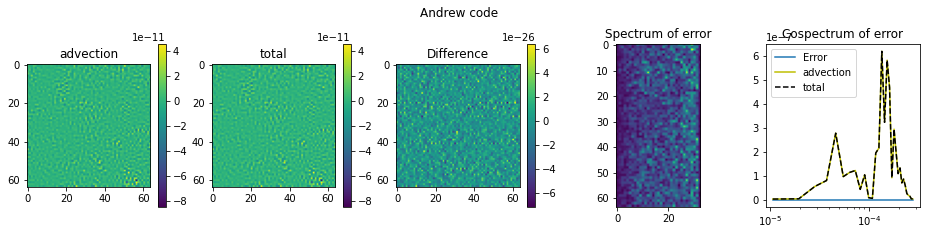

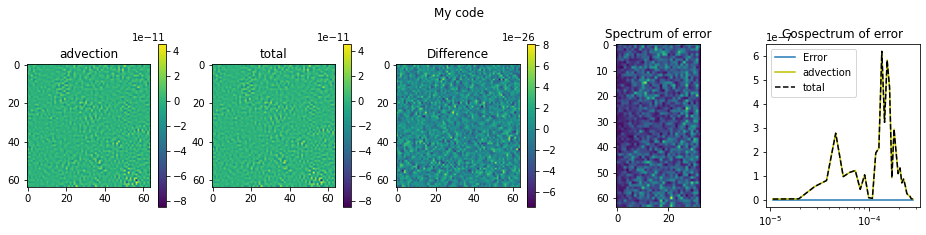

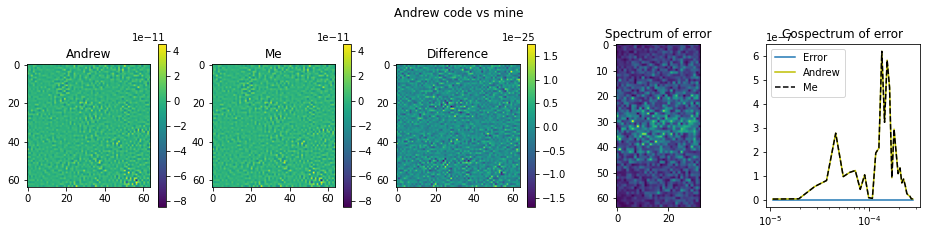

In [196]:
plot_advection_total(ppb.Operator1, op.Operator1)

INFO:  Logger initialized


mean Andrew = 2.3665827156630354e-29, mean Me = 8.204153414298523e-29
Relative error = 0.0012553256473551713


INFO:  Logger initialized


mean Andrew = -3.155443620884047e-29, mean Me = -7.178634237511207e-29
Relative error = 0.00125532564735517
mean Andrew = 8.204153414298523e-29, mean Me = -7.178634237511207e-29
Relative error = 4.715711235264399e-29


INFO:  Logger initialized


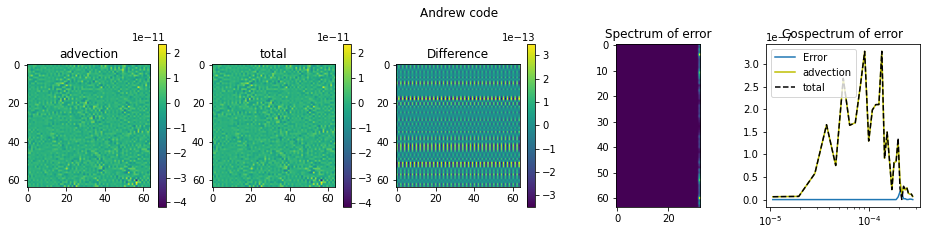

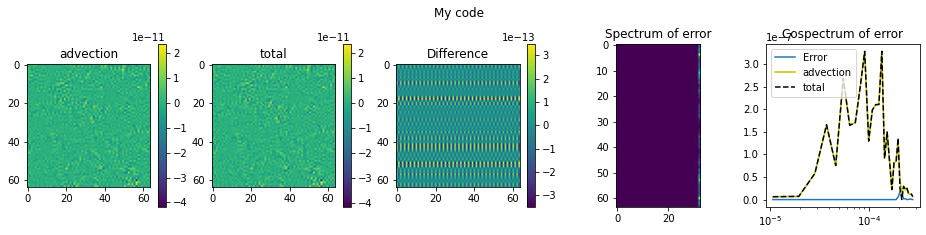

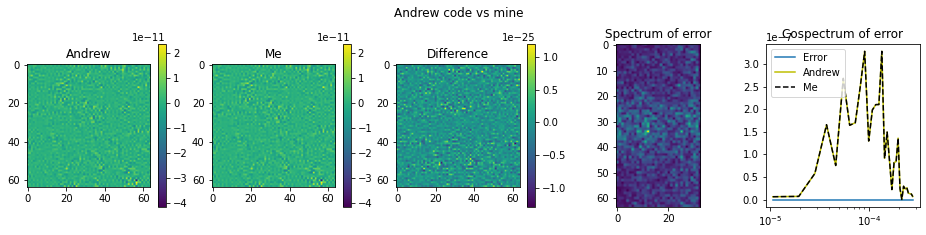

In [197]:
plot_advection_total(ppb.Operator2, op.Operator2)

INFO:  Logger initialized


mean Andrew = -4.9698237028923744e-29, mean Me = -4.614836295542919e-29
Relative error = 0.10261356691233742


INFO:  Logger initialized


mean Andrew = -6.03478592494074e-29, mean Me = -4.614836295542919e-29
Relative error = 0.10261356691233739


INFO:  Logger initialized


mean Andrew = -4.614836295542919e-29, mean Me = -4.614836295542919e-29
Relative error = 0.0


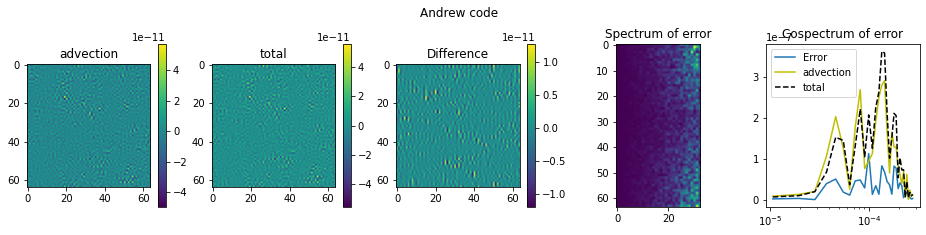

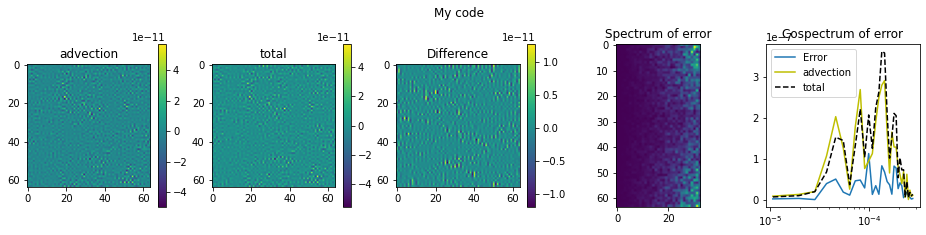

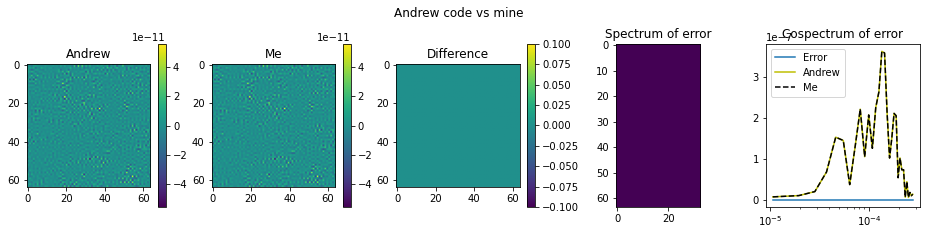

In [198]:
plot_advection_total(ppb.Operator3, op.Operator3)

# True total subgrid forcing

In [201]:
def plot_advection_true_total(opMe):
    qf = op.Operator3(q, 64)[0]
    
    total = op.PV_forcing_total(q.values, 64, opMe, {})[0]
    total_true = op.PV_forcing_true_total(q.values, 64, opMe, {})[0]
    plot_error(total, total_true, qf, labels=('total', 'true total'))
    plt.yscale('log')

INFO:  Logger initialized


mean Andrew = -1.199068575935938e-28, mean Me = 1.2249432136271871e-26
Relative error = 17.017392045413565


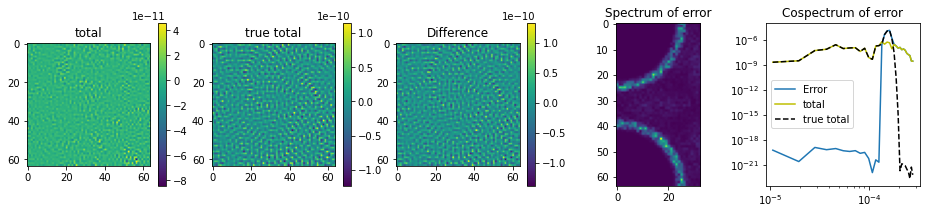

In [202]:
plot_advection_true_total(op.Operator1)

mean Andrew = -7.178634237511207e-29, mean Me = 1.520292736541934e-26
Relative error = 234.4097335353645


INFO:  Logger initialized


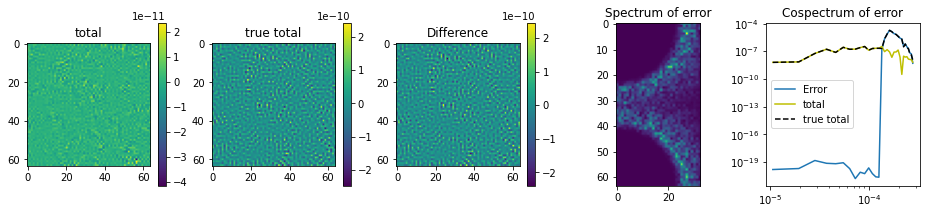

In [203]:
plot_advection_true_total(op.Operator2)

INFO:  Logger initialized


mean Andrew = -4.614836295542919e-29, mean Me = 1.1145026868962455e-26
Relative error = 192.39276626345028


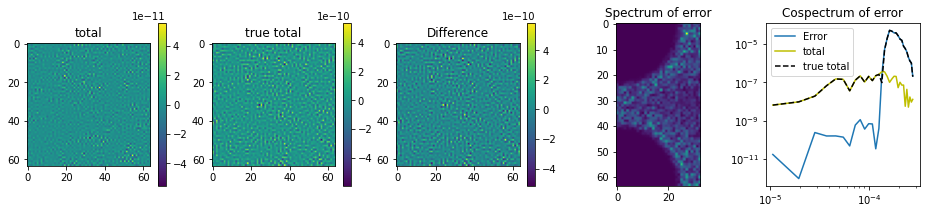

In [204]:
plot_advection_true_total(op.Operator3)

### Note: pyqg_subgrid_experiments do essentially the same, i.e. save time tendency 

# Subgrid forcing at various resolutions of DNS

In [205]:
def plot_different_DNS_resolution(opMe):
    qf = op.Operator3(q, 64)[0]
    
    forcing = op.PV_subgrid_forcing(q.values, 64, opMe, {})[0]
    q1 = op.cut_off(q.values, 128)
    forcing1 = op.PV_subgrid_forcing(q1, 64, opMe, {})[0]
    plot_error(forcing, forcing1, qf, labels=('DNS data', 'DNS $128^2$ data'))

INFO:  Logger initialized


mean Andrew = -1.9484864358958992e-28, mean Me = 3.865418435582958e-29
Relative error = 0.0002912715099227227


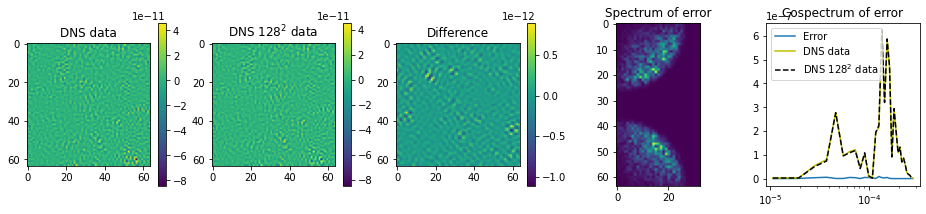

In [206]:
plot_different_DNS_resolution(op.Operator1)

INFO:  Logger initialized


mean Andrew = -3.155443620884047e-29, mean Me = -2.524354896707238e-29
Relative error = 0.0010126639237267206


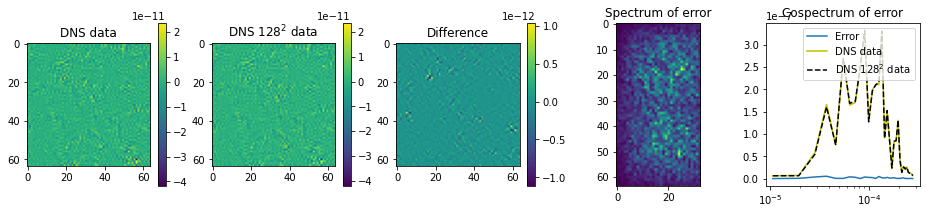

In [207]:
plot_different_DNS_resolution(op.Operator2)

INFO:  Logger initialized


mean Andrew = -6.03478592494074e-29, mean Me = 1.0255191767873153e-28
Relative error = 0.3474342682873744


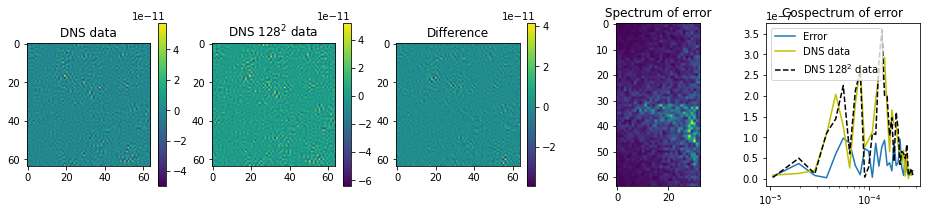

In [208]:
plot_different_DNS_resolution(op.Operator3)

# Subgrid forcing at various resolution of coarse model

In [232]:
def plot_different_coarse_resolution(opMe, *ncs):
    plt.figure(figsize=(12,6))
    for j, nc in enumerate(ncs):
        plt.subplot(2,len(ncs),j+1)
        forcing = op.PV_subgrid_forcing(q.values, nc, opMe, {})
        plt.imshow(forcing[0]); plt.title(f'(Upper), {nc}'); plt.colorbar()
        
        plt.subplot(2,len(ncs),j+1+len(ncs))
        forcing = op.PV_subgrid_forcing(q.values, nc, opMe, {})
        plt.imshow(forcing[1]); plt.title(f'(Lower), {nc}'); plt.colorbar()

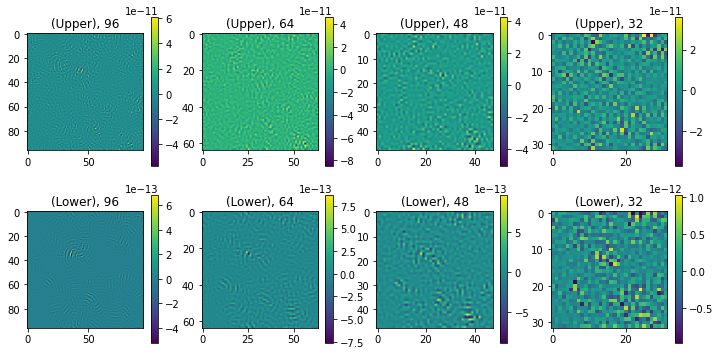

In [235]:
plot_different_coarse_resolution(op.Operator1, 96, 64, 48, 32)

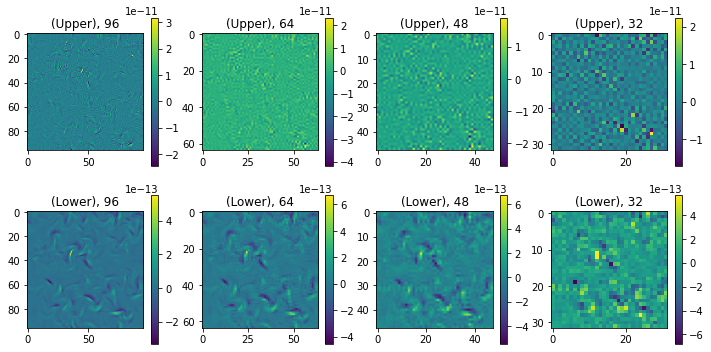

In [234]:
plot_different_coarse_resolution(op.Operator2, 96, 64, 48, 32)

# Gaussian noise as initial condition

INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized


4.384505333096387e-07
-5.88217324482153e-24


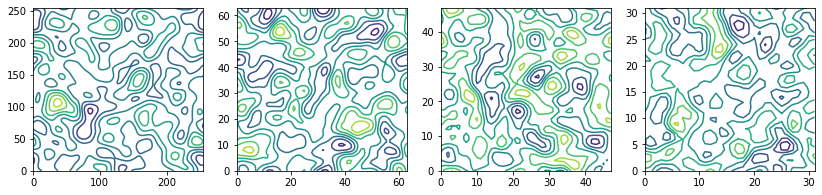

In [86]:
plt.figure(figsize=(14,3))
plt.subplot(1,4,1);plt.contour(pyqg.QGModel(nx=256).gaussian_field())
plt.subplot(1,4,2);plt.contour(pyqg.QGModel(nx=64).gaussian_field())
plt.subplot(1,4,3);plt.contour(pyqg.QGModel(nx=48).gaussian_field())
plt.subplot(1,4,4);plt.contour(pyqg.QGModel(nx=32).gaussian_field())
print(pyqg.QGModel(nx=48).gaussian_field().std())
print(pyqg.QGModel(nx=48).gaussian_field().mean())

In [434]:
m = pyqg.QGModel(tmax=86400*360*10, twrite=10000)
ds = []
for t in m.run_with_snapshots(tsnapint=1000*3600):
    ds.append(m.to_dataset())
old_noise = xr.concat(ds, dim='time')

INFO:  Logger initialized
INFO: Step: 10000, Time: 7.20e+07, KE: 2.96e-04, CFL: 0.074
INFO: Step: 20000, Time: 1.44e+08, KE: 5.05e-04, CFL: 0.092
INFO: Step: 30000, Time: 2.16e+08, KE: 4.68e-04, CFL: 0.103
INFO: Step: 40000, Time: 2.88e+08, KE: 5.72e-04, CFL: 0.101


In [435]:
m = pyqg.QGModel(tmax=86400*360*10, twrite=10000)
m.set_q1q2(m.gaussian_field(), 0*m.x)
ds = []
for t in m.run_with_snapshots(tsnapint=1000*3600):
    ds.append(m.to_dataset())
new_noise = xr.concat(ds, dim='time')

INFO:  Logger initialized
INFO: Step: 10000, Time: 7.20e+07, KE: 2.25e-04, CFL: 0.073
INFO: Step: 20000, Time: 1.44e+08, KE: 5.36e-04, CFL: 0.098
INFO: Step: 30000, Time: 2.16e+08, KE: 4.68e-04, CFL: 0.095
INFO: Step: 40000, Time: 2.88e+08, KE: 5.05e-04, CFL: 0.112


In [436]:
def KE(dataset):
    return (op.ave_lev((dataset.u**2 + dataset.v**2)*0.5, 0.25)).mean(dim=('x','y'))

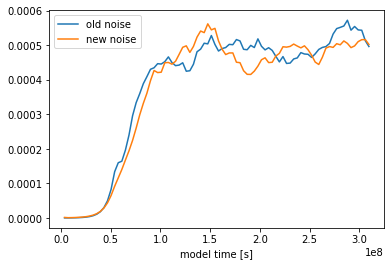

In [437]:
KE(old_noise).plot(label='old noise')
KE(new_noise).plot(label='new noise')
plt.legend()

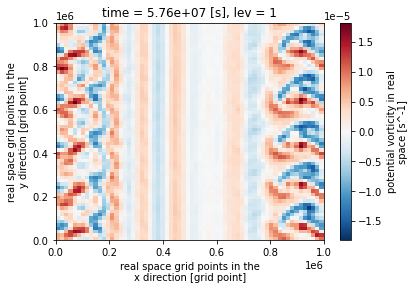

In [438]:
old_noise.q.isel(time=15, lev=0).plot()

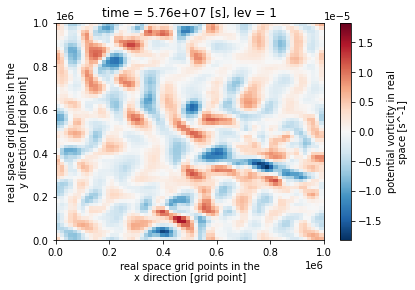

In [439]:
new_noise.q.isel(time=15,lev=0).plot()

In [456]:
m = pyqg.QGModel(tmax=86400*30)
m.q.mean(axis=(1,2))
for t in m.run_with_snapshots():
    print(m.q.mean(axis=(1,2)))

INFO:  Logger initialized


[3.30872245e-24 0.00000000e+00]
[3.30872245e-24 0.00000000e+00]
[-3.30872245e-24 -4.13590306e-25]
[3.30872245e-24 0.00000000e+00]
[ 0.00000000e+00 -8.27180613e-25]
[-3.30872245e-24  0.00000000e+00]
